In [3]:
import sklearn as sk
import matplotlib as plt
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [4]:
data = pd.read_csv('../../Data/full_data.csv',low_memory=False)
columns_to_remove = ['Unnamed: 0','lastTradeDate','address1', 'city', 'country', 'industry', 'sector','recommendationKey','expirationDate','exchange','timeZoneShortName','ticker','state']
data.drop(columns_to_remove, axis = 1, inplace= True)
#data = pd.get_dummies(data, columns=['ticker','state'])
data = data.replace({"False": 0, "True": 1})
data = data.replace({False: 0, True: 1})
data

,strike,price,bid,ask,change,percentChange,volume,openInterest,sigma,inTheMoney,...,returnOnAssets,returnOnEquity,freeCashflow,operatingCashflow,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins,tau,tau2
0,210.0,199.70,417.49,418.06,0.000000,0.000000,19275689.0,0.0,0.223118,1.0,...,0.15190,0.39174,5.868100e+10,1.026470e+11,0.176,0.69815,0.52037,0.43586,0.055556,0.054795
1,220.0,200.32,417.49,418.06,-9.569992,-4.559527,19275689.0,2.0,0.223118,1.0,...,0.15190,0.39174,5.868100e+10,1.026470e+11,0.176,0.69815,0.52037,0.43586,0.003968,0.002740
2,230.0,189.90,417.49,418.06,1.399994,0.742702,19275689.0,3.0,0.223118,1.0,...,0.15190,0.39174,5.868100e+10,1.026470e+11,0.176,0.69815,0.52037,0.43586,0.003968,0.002740
3,235.0,174.91,417.49,418.06,0.000000,0.000000,19275689.0,6.0,0.223118,1.0,...,0.15190,0.39174,5.868100e+10,1.026470e+11,0.176,0.69815,0.52037,0.43586,0.126984,0.120548
4,250.0,170.23,417.49,418.06,-9.120010,-5.085035,19275689.0,6.0,0.223118,1.0,...,0.15190,0.39174,5.868100e+10,1.026470e+11,0.176,0.69815,0.52037,0.43586,0.003968,0.002740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73149,2.0,0.05,1.71,2.34,0.000000,0.000000,124821.0,1382.0,1.064334,1,...,-0.10972,0.10401,2.431477e+08,5.283660e+08,-0.425,0.03447,-0.18544,-0.18645,0.365079,0.350685
73150,3.0,0.15,1.71,2.34,0.000000,0.000000,124821.0,12.0,1.064334,0,...,-0.10972,0.10401,2.431477e+08,5.283660e+08,-0.425,0.03447,-0.18544,-0.18645,0.519841,0.501370
73151,4.0,0.16,1.71,2.34,0.000000,0.000000,124821.0,1.0,1.064334,0,...,-0.10972,0.10401,2.431477e+08,5.283660e+08,-0.425,0.03447,-0.18544,-0.18645,0.686508,0.660274
73152,1.0,0.25,1.71,2.34,0.000000,0.000000,124821.0,1.0,1.064334,0,...,-0.10972,0.10401,2.431477e+08,5.283660e+08,-0.425,0.03447,-0.18544,-0.18645,0.464286,0.446575


In [5]:
ann3_call_data = data[data.call == 1]
ann3_put_data = data[data.call == 0]

ann3_call_data.drop('call', axis = 1, inplace = True)
ann3_put_data.drop('call', axis = 1, inplace = True)

C:\Users\Domenico\AppData\Local\Temp\ipykernel_1208\3503652102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ann3_call_data.drop('call', axis = 1, inplace = True)
C:\Users\Domenico\AppData\Local\Temp\ipykernel_1208\3503652102.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ann3_put_data.drop('call', axis = 1, inplace = True)


In [7]:
ann3_call_data = pd.DataFrame(ann3_call_data)

y = ann3_call_data['price']
X = ann3_call_data.drop("price", axis=1)

X = np.nan_to_num(np.array(X, dtype=np.float32), nan=0.0, posinf=1e10, neginf=-1e10)
y = np.nan_to_num(np.array(y, dtype=np.float32), nan=0.0, posinf=1e10, neginf=-1e10)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


def build_ann_model(input_shape):
    model = Sequential()

    model.add(Dense(1000, input_shape=(input_shape,), kernel_regularizer=l2(1e-5)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.001)) 

    model.add(Dense(1000, kernel_regularizer=l2(1e-5)))  
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.001))  

    model.add(Dense(1000, kernel_regularizer=l2(1e-5)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.001)) 

    model.add(Dense(1000, kernel_regularizer=l2(1e-5)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.001))  

    model.add(Dense(1, activation='relu'))

    return model

input_shape = X_train.shape[1]
ANN3_call = build_ann_model(input_shape)

ANN3_call.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = ANN3_call.fit(X_train, y_train,validation_split=0.4,epochs=500, 
                        verbose=1)

test_loss, test_mae = ANN3_call.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Mean Absolute Error: {test_mae}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


Epoch 1/500


c:\Users\Domenico\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Domenico\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


584/584 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 4570.4819 - mean_absolute_error: 14.4984 - val_loss: 1798.9749 - val_mean_absolute_error: 11.9030
Epoch 2/500
584/584 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 2571.7034 - mean_absolute_error: 11.9258 - val_loss: 1143.2899 - val_mean_absolute_error: 8.8442
Epoch 3/500
584/584 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 2085.7419 - mean_absolute_error: 11.2060 - val_loss: 1089.5787 - val_mean_absolute_error: 8.1062
Epoch 4/500
584/584 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 1206.4655 - mean_absolute_error: 9.1659 - val_loss: 952.4044 - val_mean_absolute_error: 7.8677
Epoch 5/500
584/584 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 1417.7161 - mean_absolute_error: 8.9996 - val_loss: 798.0739 - val_mean_absolute_error: 7.9045
Epoch 6/500
584/584 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 700.9732 - mean_absolute_error: 7.6899 - val_loss: 640.1640 - val_mean_absolute_error: 6.9189
Epoch 7/500
584/584 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - l

KeyboardInterrupt: 

In [45]:
ANN3_call.save('models\\ann3\ANN3_call.keras')

Epoch 1/500
3/3 [==============================] - 6s 337ms/step - loss: 87.1085 - mean_absolute_error: 3.9267 - val_loss: 138.2262 - val_mean_absolute_error: 4.6515 - lr: 5.0000e-04
Epoch 2/500
3/3 [==============================] - 0s 158ms/step - loss: 73.3840 - mean_absolute_error: 3.4928 - val_loss: 137.2842 - val_mean_absolute_error: 4.6175 - lr: 5.0000e-04
Epoch 3/500
3/3 [==============================] - 1s 204ms/step - loss: 66.8028 - mean_absolute_error: 3.0933 - val_loss: 135.1212 - val_mean_absolute_error: 4.5705 - lr: 5.0000e-04
Epoch 4/500
3/3 [==============================] - 1s 196ms/step - loss: 63.9118 - mean_absolute_error: 3.0416 - val_loss: 136.0468 - val_mean_absolute_error: 4.6041 - lr: 5.0000e-04
Epoch 5/500
3/3 [==============================] - 1s 205ms/step - loss: 64.2227 - mean_absolute_error: 3.0774 - val_loss: 136.8043 - val_mean_absolute_error: 4.6388 - lr: 5.0000e-04
Epoch 6/500
3/3 [==============================] - 1s 203ms/step - loss: 60.5533 - me

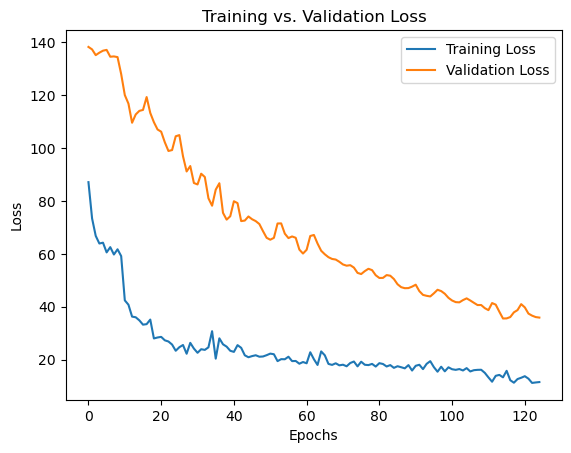

In [46]:
ann3_put_data = pd.DataFrame(ann3_put_data)

y = ann3_put_data['price']
X = ann3_put_data.drop("price", axis=1)

X = np.nan_to_num(np.array(X, dtype=np.float32), nan=0.0, posinf=1e10, neginf=-1e10)
y = np.nan_to_num(np.array(y, dtype=np.float32), nan=0.0, posinf=1e10, neginf=-1e10)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

def build_ann_model(input_shape):
    model = Sequential()

    model.add(Dense(1000, input_shape=(input_shape,), kernel_regularizer=l2(1e-5)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.001)) 

    model.add(Dense(1000, kernel_regularizer=l2(1e-5))) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.001))  

    model.add(Dense(1000, kernel_regularizer=l2(1e-5)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.001))  

    model.add(Dense(1000, kernel_regularizer=l2(1e-5)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.001))  

    model.add(Dense(1, activation='sigmoid'))

    return model

input_shape = X_train.shape[1]
ANN3_put = build_ann_model(input_shape)

ANN3_put.compile(optimizer=Adam(learning_rate=0.0005), 
                 loss='mean_squared_error', 
                 metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = ANN3_put.fit(X_train, y_train, validation_split=0.4, epochs=500, 
                       batch_size=300,  
                       callbacks=[early_stopping, reduce_lr],
                       verbose=1)

test_loss, test_mae = ANN3_put.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Mean Absolute Error: {test_mae}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

In [47]:
ANN3_put.save('models\\ann3\ANN3_put.keras')